In [1]:
#imports libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#imports for acquire and prep
from env import get_db_url
import os
import acquire

In [2]:
#using acquire code and file to call in curriculum_log data:
df = acquire.get_curriculum_data()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   ip          900223 non-null  object 
 5   name        847330 non-null  object 
 6   start_date  847330 non-null  object 
 7   end_date    847330 non-null  object 
 8   program_id  847330 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 68.7+ MB


,date,time,path,user_id,ip,name,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [3]:
df[df.user_id ==539]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
388308,2019-11-04,16:19:26,/,539,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0
388309,2019-11-04,16:19:34,toc,539,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0
388399,2019-11-04,16:54:02,html-css,539,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0
388405,2019-11-04,16:54:38,html-css/introduction,539,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0
388407,2019-11-04,16:54:45,html-css/elements,539,97.105.19.58,Europa,2019-11-04,2020-04-17,2.0
...,...,...,...,...,...,...,...,...,...
851208,2021-03-17,12:08:25,html-css/css-i,539,70.123.228.62,Staff,2014-02-04,2014-02-04,2.0
851209,2021-03-17,12:08:31,html-css/forms,539,70.123.228.62,Staff,2014-02-04,2014-02-04,2.0
851211,2021-03-17,12:08:43,html-css,539,70.123.228.62,Staff,2014-02-04,2014-02-04,2.0
851212,2021-03-17,12:08:59,/,539,70.123.228.62,Staff,2014-02-04,2014-02-04,2.0


In [4]:
#Question: are user_ids being recycled? 
#And was there another website for cohorts in 2014?
df[df.user_id == 64]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
1447,2018-01-29,13:50:57,/,64,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
1448,2018-01-29,13:51:00,mkdocs/search_index.json,64,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
1450,2018-01-29,13:51:04,mysql/users,64,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
1967,2018-01-30,10:13:09,/,64,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
1968,2018-01-30,10:13:12,spring,64,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
...,...,...,...,...,...,...,...,...,...
900216,2021-04-21,16:41:49,jquery,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
900218,2021-04-21,16:41:51,jquery/personal-site,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0


In [5]:
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            900213, 900214, 900215, 900216, 900217, 900218, 900219, 900220,
            900221, 900222],
           dtype='int64', length=900223)

In [6]:
df.columns

Index(['date', 'time', 'path', 'user_id', 'ip', 'name', 'start_date',
       'end_date', 'program_id'],
      dtype='object')

In [7]:
#looking at the stats numbers for the dataset:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,900223.0,458.825707,249.296767,1.0,269.0,475.0,660.0,981.0
program_id,847330.0,2.086004,0.388231,1.0,2.0,2.0,2.0,4.0


### Take aways:
- `date`/ `time` / `start_date` and `end_date` needs to be run through `pd.to_datetime`
- `date` could also become new index
- it could be helpful to create a `program_name` column
- setting `ip` as float will allow boxplots and other charts for anomaly checks.

In [8]:
#passing df through pd.to_datetime for date and time format/dtype for all date/time columns
#df.date = pd.to_datetime(df.date)
#df.start_date = pd.to_datetime(df.start_date)
#df.end_date = pd.to_datetime(df.end_date)
#setting date as the index
#df = df.set_index('date')

In [9]:
def date_dtypes_index(df):
    """passing df through pd.to_datetime for date and time format/dtype for all date/time columns;
    and combining date + time and setting as index"""
    df['access_date'] = df['date'] + ' ' + df['time']
    df.access_date = pd.to_datetime(df.access_date)
    df.start_date = pd.to_datetime(df.start_date)
    df.end_date = pd.to_datetime(df.end_date)
    df = df[df.end_date <= pd.to_datetime("today")]
    #setting date as the index
    df = df.set_index('access_date')
    return df

In [10]:
df = date_dtypes_index(df)
df.head()

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [11]:
#checking dtypes:
df.dtypes

date                  object
time                  object
path                  object
user_id                int64
ip                    object
name                  object
start_date    datetime64[ns]
end_date      datetime64[ns]
program_id           float64
dtype: object

In [12]:
#checking new index:
df.index

DatetimeIndex(['2018-01-26 09:55:03', '2018-01-26 09:56:02',
               '2018-01-26 09:56:05', '2018-01-26 09:56:06',
               '2018-01-26 09:56:24', '2018-01-26 09:56:41',
               '2018-01-26 09:56:46', '2018-01-26 09:56:48',
               '2018-01-26 09:56:59', '2018-01-26 09:58:26',
               ...
               '2021-04-21 16:38:14', '2021-04-21 16:41:29',
               '2021-04-21 16:41:31', '2021-04-21 16:41:49',
               '2021-04-21 16:41:51', '2021-04-21 16:41:51',
               '2021-04-21 16:42:02', '2021-04-21 16:42:09',
               '2021-04-21 16:44:37', '2021-04-21 16:44:39'],
              dtype='datetime64[ns]', name='access_date', length=847330, freq=None)

In [13]:
#adding in datetime columns to find stats values:
df.describe(datetime_is_numeric=True)

,user_id,start_date,end_date,program_id
count,847330.000000,847330,847330,847330.000000
mean,456.707344,2018-12-24 09:55:56.790860800,2019-05-11 21:08:19.869472512,2.086004
min,1.000000,2014-02-04 00:00:00,2014-02-04 00:00:00,1.000000
25%,263.000000,2018-05-29 00:00:00,2018-10-11 00:00:00,2.000000
50%,476.000000,2019-07-15 00:00:00,2019-12-11 00:00:00,2.000000
75%,648.000000,2020-03-23 00:00:00,2020-08-20 00:00:00,2.000000
max,981.000000,2021-04-12 00:00:00,2021-10-01 00:00:00,4.000000
std,250.734201,NaN,NaN,0.388231


In [14]:
## non curriculum pages (Ray's codes)
def drop_noncurriculum(df):
    df=df[df.path != '/']
    df=df[df.path != 'toc']
    df=df[df.path.str.contains('jpeg') != True]
    df=df[df.path.str.contains('json') != True]
    df=df[df.path.str.contains('jpg') != True]
    df=df[df.path.str.contains('appendix') != True]
    df=df[df.path.str.contains('Appendix') != True]
    return df

In [15]:
df = drop_noncurriculum(df)
df

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21,16:41:51,jquery/personal-site,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
2021-04-21 16:42:02,2021-04-21,16:42:02,jquery/mapbox-api,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
2021-04-21 16:42:09,2021-04-21,16:42:09,jquery/ajax/weather-map,64,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0


In [16]:
def drop_other(df):
    df=df[df.program_id != 4.0]
    df=df[df.name !='Staff']
    return df

In [17]:
df = drop_other(df)
df.head()

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [18]:
# assigns values in program_id their program name
df.loc[df['program_id'] == 1.0, 'program_id'] = 'Web Development'
df.loc[df['program_id'] == 2.0, 'program_id'] = 'Web Development'         
df.loc[df['program_id'] == 3.0, 'program_id'] = 'Data Science'

_______________________________________________

### Looking at nulls and anomalies:

In [19]:
#out of the 90,223 rows and 9 columns, what nulls are in the data?
df.isnull().sum()

date          0
time          0
path          1
user_id       0
ip            0
name          0
start_date    0
end_date      0
program_id    0
dtype: int64

#### Checking anomalies on ip addresses 

In [20]:
#looking at ip column for outliers:
df.ip.value_counts()

97.105.19.58       213995
97.105.19.61        53653
192.171.117.210      7784
67.11.50.23          3849
172.124.67.93        2986
                    ...  
172.56.6.62             1
174.244.67.71           1
99.203.26.118           1
172.58.107.160          1
107.77.169.13           1
Name: ip, Length: 4555, dtype: int64

In [21]:
#defining a function to create a temp df for anomaly counts/frequencies:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
    s.value_counts(dropna=False).rename('count'),
    s.value_counts(dropna=False, normalize=True).rename('proba'),
    left_index=True,
    right_index=True,
    )

ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,213995,0.332168
97.105.19.61,53653,0.083281
192.171.117.210,7784,0.012083
67.11.50.23,3849,0.005975
172.124.67.93,2986,0.004635


In [22]:
#looking at ip addresses that have the lowest frequencies occuring
df[df.ip == '172.58.109.140']

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,


In [23]:
#looking at ip addresses that have the lowest frequencies occuring
df[df.ip == '99.203.213.59']

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,


In [24]:
#looking at ip addresses that have the lowest frequencies occuring
df[df.ip == '72.181.124.244']

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,


#### interesting find/note about some of the nulls:

In [25]:
#This last user_id had nulls. When following it, this shows that possible nulls might be when students are
#going through their prework phase at Codeup...good to know for another time...
df[df.user_id == 88]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-06-01 15:14:19,2018-06-01,15:14:19,javascript-ii,88,66.90.136.214,Glacier,2015-06-05,2015-10-06,Web Development
2018-06-01 15:15:07,2018-06-01,15:15:07,javascript-ii,88,66.90.136.214,Glacier,2015-06-05,2015-10-06,Web Development
2018-06-01 15:15:13,2018-06-01,15:15:13,javascript-ii,88,66.90.136.214,Glacier,2015-06-05,2015-10-06,Web Development
2018-06-01 15:15:17,2018-06-01,15:15:17,php,88,66.90.136.214,Glacier,2015-06-05,2015-10-06,Web Development
2018-06-01 15:16:54,2018-06-01,15:16:54,content/php_i,88,66.90.136.214,Glacier,2015-06-05,2015-10-06,Web Development
...,...,...,...,...,...,...,...,...,...
2021-01-11 15:04:06,2021-01-11,15:04:06,content/html-css/introduction.html,88,136.50.6.131,Glacier,2015-06-05,2015-10-06,Web Development
2021-01-11 15:04:06,2021-01-11,15:04:06,content/html-css/gitbook/images/favicon.ico,88,136.50.6.131,Glacier,2015-06-05,2015-10-06,Web Development
2021-01-11 15:04:08,2021-01-11,15:04:08,content/html-css/elements.html,88,136.50.6.131,Glacier,2015-06-05,2015-10-06,Web Development


In [26]:
#possible webscraper
df[df.user_id == 48]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,


In [27]:
# assigns values in program_id their program name
df.loc[df['program_id'] == 1.0, 'program_id'] = 'Web Development'
df.loc[df['program_id'] == 2.0, 'program_id'] = 'Web Development'         
df.loc[df['program_id'] == 3.0, 'program_id'] = 'Data Science'

#### Next steps: 
- Turning `ip` into int?? (UPDATE: not needed. can be explored w/o ...verified by Ryan O.
- Handling nulls

### What is needed?
- Most frequent lessons logged into (per program)
    - Lesson counts
    - Program id/name
- Most/least frequent lessons logged into (per cohort)
    - Lesson log counts
    - name (cohort)
- Active students that do not engage with curriculum?
    - user_id frequency counts
    - current dates of cohorts
    - ip addresses?
- Suspicious activity and any webscrapping happening?
    - time (looking at odd hours of day)
    - ip addresses and no cohorts attached
    - user_id?
- 2019 dataframe showing shutoff of cross program curriculum access
    - program id and path page counts (?)
    - date (only 2019)
- Topics (path) alumni are still using?
    - path frequencies
    - anything > end_date of cohorts
- Least accessed lessons (overall)
    - path frequencies
- Anything else??


## Looking at Nulls:

In [28]:
#checking nulls:
df.isnull().sum()

date          0
time          0
path          1
user_id       0
ip            0
name          0
start_date    0
end_date      0
program_id    0
dtype: int64

In [29]:
#who dis? 
df[df.user_id == 53]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-01-28 18:48:19,2018-01-28,18:48:19,index.html,53,67.10.161.55,Lassen,2016-07-18,2016-11-10,Web Development
2018-01-28 18:48:24,2018-01-28,18:48:24,html-css,53,67.10.161.55,Lassen,2016-07-18,2016-11-10,Web Development
2018-01-28 18:49:20,2018-01-28,18:49:20,javascript-i,53,67.10.161.55,Lassen,2016-07-18,2016-11-10,Web Development
2018-01-28 18:49:23,2018-01-28,18:49:23,javascript-i/conditionals,53,67.10.161.55,Lassen,2016-07-18,2016-11-10,Web Development
2018-01-28 18:50:41,2018-01-28,18:50:41,javascript-i/conditionals,53,67.10.161.55,Lassen,2016-07-18,2016-11-10,Web Development
...,...,...,...,...,...,...,...,...,...
2020-01-22 13:33:12,2020-01-22,13:33:12,spring/fundamentals/form-model-binding,53,97.105.19.58,Lassen,2016-07-18,2016-11-10,Web Development
2020-01-23 09:47:35,2020-01-23,09:47:35,index.html,53,97.105.19.58,Lassen,2016-07-18,2016-11-10,Web Development
2020-01-23 09:47:41,2020-01-23,09:47:41,java-ii,53,97.105.19.58,Lassen,2016-07-18,2016-11-10,Web Development


In [30]:
df.program_id.value_counts()

Web Development    566427
Data Science        77810
Name: program_id, dtype: int64

In [31]:
df2 = df.groupby(['user_id'])['name'].count()
df2

user_id
1      1214
2      1382
3      1390
4       605
5      1493
       ... 
976      26
977      83
978      32
979     104
981      39
Name: name, Length: 873, dtype: int64

In [32]:
df.path.value_counts()[55:100
                      ]

spring/setup                                   4085
jquery/events/mouse-events                     4009
jquery/introduction                            4007
jquery/essential-methods/attributes-and-css    3999
javascript-i/introduction/variables            3949
jquery/ajax/requests-and-responses             3944
java-iii/user-input                            3936
javascript-i/bom-and-dom/bom                   3902
jquery/ajax/weather-map                        3876
spring/fundamentals/relationships              3841
html-css/introduction                          3830
mysql/relationships/joins                      3823
jquery/essential-methods/traversing            3750
javascript-ii/npm                              3731
jquery/effects                                 3606
java-ii/file-io                                3578
html-css/css-i/introduction                    3456
java-i/strings                                 3445
mysql/database-design                          3440
spring/funda

## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
Active students that do not engage with curriculum? 
- user_id frequency counts
- current dates of cohorts
- ip addresses?


In [33]:
#creating a df that holds students (user_id) that have accessed curriculum less than 5 times:
df3  = df.user_id.value_counts() 
df3

53     7682
344    5017
495    5000
570    3801
423    3294
       ... 
857       1
348       1
212       1
593       1
165       1
Name: user_id, Length: 873, dtype: int64

In [34]:
df3 = pd.DataFrame(df.user_id.value_counts() < 5)
df3

,user_id
53,False
344,False
495,False
570,False
423,False
...,...
857,True
348,True
212,True
593,True


In [35]:
#all of the user_id that are accessing curriculum 4 times or less
df3[df3.user_id == True]

,user_id
95,True
679,True
71,True
246,True
399,True
956,True
539,True
216,True
177,True
81,True


Looking at each of these students to learn more:

In [36]:
#user 95 (wondering if this is a webscraper? start date and access dates do not make sense)
df[df.user_id == 95]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-02-10 11:01:13,2018-02-10,11:01:13,html-css,95,24.26.238.218,Arches,2014-02-04,2014-04-22,Web Development
2018-02-10 11:01:54,2018-02-10,11:01:54,slides/mvc,95,24.26.238.218,Arches,2014-02-04,2014-04-22,Web Development
2018-02-10 11:02:08,2018-02-10,11:02:08,html-css/introduction,95,24.26.238.218,Arches,2014-02-04,2014-04-22,Web Development
2018-02-10 11:02:29,2018-02-10,11:02:29,html-css/css-i/selectors-and-properties,95,24.26.238.218,Arches,2014-02-04,2014-04-22,Web Development


In [37]:
#user 679: maybe they quit??
df[df.user_id == 679]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2020-07-13 14:39:21,2020-07-13,14:39:21,13-advanced-topics/1-tidy-data,679,24.28.146.155,Darden,2020-07-13,2021-01-12,Data Science
2020-07-13 14:39:36,2020-07-13,14:39:36,1-fundamentals/1.1-intro-to-data-science,679,24.28.146.155,Darden,2020-07-13,2021-01-12,Data Science
2020-07-13 15:49:31,2020-07-13,15:49:31,1-fundamentals/1.1-intro-to-data-science,679,24.28.146.155,Darden,2020-07-13,2021-01-12,Data Science
2020-07-14 08:05:15,2020-07-14,08:05:15,1-fundamentals/1.1-intro-to-data-science,679,24.28.146.155,Darden,2020-07-13,2021-01-12,Data Science


In [38]:
#user 71 : access dates and start_date do not coincide..
df[df.user_id == 71]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-01-30 15:01:14,2018-01-30,15:01:14,content/html-css,71,173.173.116.10,Quincy,2017-06-05,2017-09-22,Web Development
2018-01-30 15:01:21,2018-01-30,15:01:21,content/git,71,173.173.116.10,Quincy,2017-06-05,2017-09-22,Web Development
2018-01-30 15:01:28,2018-01-30,15:01:28,content/git/creating-a-repository.html,71,173.173.116.10,Quincy,2017-06-05,2017-09-22,Web Development
2018-01-30 15:01:40,2018-01-30,15:01:40,content/git/initializing-a-repository.html,71,173.173.116.10,Quincy,2017-06-05,2017-09-22,Web Development


In [39]:
#user 246 : looks like webscaper | odd sign-in times and access/start dates do not match
df[df.user_id == 246]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-08-23 23:24:13,2018-08-23,23:24:13,index.html,246,107.77.210.31,Lassen,2016-07-18,2016-11-10,Web Development
2018-08-23 23:24:37,2018-08-23,23:24:37,content/mysql/intro-to-mysql,246,107.77.210.31,Lassen,2016-07-18,2016-11-10,Web Development
2018-08-23 23:24:37,2018-08-23,23:24:37,content/mysql/intro-to-mysql/gitbook/images/fa...,246,107.77.210.31,Lassen,2016-07-18,2016-11-10,Web Development
2018-08-24 00:00:18,2018-08-24,00:00:18,content/mysql/intro-to-mysql/databases.html,246,107.77.210.31,Lassen,2016-07-18,2016-11-10,Web Development


In [40]:
#user 399: pathways and quick scan times look like a webscraper
df[df.user_id == 399]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2019-04-13 16:37:57,2019-04-13,16:37:57,content/jquery/ajax,399,24.227.245.186,Quincy,2017-06-05,2017-09-22,Web Development
2019-04-13 16:37:57,2019-04-13,16:37:57,content/jquery/ajax/gitbook/images/favicon.ico,399,24.227.245.186,Quincy,2017-06-05,2017-09-22,Web Development
2019-04-13 16:38:14,2019-04-13,16:38:14,content/jquery/ajax/ajax-intro.html,399,24.227.245.186,Quincy,2017-06-05,2017-09-22,Web Development


In [41]:
#user 956: looks like a student that my have dropped out
df[df.user_id == 956]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2021-04-15 14:55:05,2021-04-15,14:55:05,javascript-i/introduction/operators,956,162.200.114.251,Oberon,2021-04-12,2021-10-01,Web Development
2021-04-15 14:56:04,2021-04-15,14:56:04,javascript-i/introduction/primitive-types,956,162.200.114.251,Oberon,2021-04-12,2021-10-01,Web Development
2021-04-15 15:32:22,2021-04-15,15:32:22,javascript-i/introduction/operators,956,162.200.114.251,Oberon,2021-04-12,2021-10-01,Web Development


In [42]:
#user 539: student that dropped?
df[df.user_id == 539]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2019-11-04 16:54:02,2019-11-04,16:54:02,html-css,539,97.105.19.58,Europa,2019-11-04,2020-04-17,Web Development
2019-11-04 16:54:38,2019-11-04,16:54:38,html-css/introduction,539,97.105.19.58,Europa,2019-11-04,2020-04-17,Web Development
2019-11-04 16:54:45,2019-11-04,16:54:45,html-css/elements,539,97.105.19.58,Europa,2019-11-04,2020-04-17,Web Development


In [43]:
#user 216: possible web scraper?
df[df.user_id == 216]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-06-28 15:45:51,2018-06-28,15:45:51,html-css,216,209.12.105.54,Niagara,2016-10-26,2017-03-09,Web Development
2018-06-28 15:45:54,2018-06-28,15:45:54,javascript-i,216,209.12.105.54,Niagara,2016-10-26,2017-03-09,Web Development
2018-06-28 15:45:59,2018-06-28,15:45:59,mysql,216,209.12.105.54,Niagara,2016-10-26,2017-03-09,Web Development


In [44]:
#user 177: path would indicate web scrap (images and favicon only)
df[df.user_id == 177]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-05-07 20:12:49,2018-05-07,20:12:49,content/laravel/intro,177,72.181.97.35,Ike,2016-01-20,2016-05-12,Web Development
2018-05-07 20:12:49,2018-05-07,20:12:49,content/laravel/intro/gitbook/images/favicon.ico,177,72.181.97.35,Ike,2016-01-20,2016-05-12,Web Development


In [45]:
#user 81: path would indicate web scrap (html and css only)
df[df.user_id == 81]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-02-03 12:04:16,2018-02-03,12:04:16,index.html,81,107.207.7.120,Pinnacles,2017-03-27,2017-07-20,Web Development
2018-02-03 12:04:45,2018-02-03,12:04:45,html-css,81,107.207.7.120,Pinnacles,2017-03-27,2017-07-20,Web Development


In [46]:
#user 169: looks like web scraper
df[df.user_id == 169]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-04-16 16:27:46,2018-04-16,16:27:46,java-iii/jdbc,169,174.207.23.151,Glacier,2015-06-05,2015-10-06,Web Development
2018-04-16 16:29:53,2018-04-16,16:29:53,java-iii/servlets,169,174.207.23.151,Glacier,2015-06-05,2015-10-06,Web Development


In [47]:
#user 85: looks like a past possible student that dropped out or never started
df[df.user_id == 85]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-02-04 11:24:05,2018-02-04,11:24:05,prework/databases,85,66.42.139.162,Denali,2014-10-20,2015-01-18,Web Development
2018-02-04 11:24:56,2018-02-04,11:24:56,prework/versioning/github,85,66.42.139.162,Denali,2014-10-20,2015-01-18,Web Development


In [48]:
#user 832: student that didn't interact with curriculum??
df[df.user_id == 832]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2020-12-07 14:22:38,2020-12-07,14:22:38,javascript-i,832,69.154.52.98,Jupiter,2020-09-21,2021-03-30,Web Development
2020-12-07 14:22:39,2020-12-07,14:22:39,html-css,832,69.154.52.98,Jupiter,2020-09-21,2021-03-30,Web Development


In [49]:
#user 97: web scraper
df[df.user_id == 97]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-02-11 20:24:07,2018-02-11,20:24:07,index.html,97,66.25.81.21,Niagara,2016-10-26,2017-03-09,Web Development
2018-02-11 20:24:17,2018-02-11,20:24:17,javascript-i,97,66.25.81.21,Niagara,2016-10-26,2017-03-09,Web Development


In [50]:
#user 857: probably student that dropped out
df[df.user_id == 857]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2021-01-13 11:19:19,2021-01-13,11:19:19,html-css,857,69.232.101.106,Fortuna,2020-01-13,2020-06-23,Web Development


In [51]:
#user 348: probably web scraper
df[df.user_id == 348]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2019-01-27 19:02:17,2019-01-27,19:02:17,content/php_iii/php-with-html/sessions-with-ph...,348,172.58.111.203,Glacier,2015-06-05,2015-10-06,Web Development


In [52]:
#user 212: probably web scraper or maybe a past student?? (is there much info from 2014?)
df[df.user_id == 212]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-06-19 09:21:08,2018-06-19,09:21:08,students/units/75/sub_units/268,212,170.248.173.247,Arches,2014-02-04,2014-04-22,Web Development


In [53]:
#user 593: probably web scraper 
df[df.user_id == 593]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2020-02-17 11:45:21,2020-02-17,11:45:21,index.html,593,167.24.104.150,Lassen,2016-07-18,2016-11-10,Web Development


In [54]:
#user 165: probably web scraper 
df[df.user_id == 165]

,date,time,path,user_id,ip,name,start_date,end_date,program_id
access_date,,,,,,,,,
2018-03-30 21:37:04,2018-03-30,21:37:04,index.html,165,24.243.3.200,Niagara,2016-10-26,2017-03-09,Web Development


#### Creating objects based on exploration of these students:

In [55]:
#creating object of known dropped students:
df_drop_students = df[df.user_id == 85],df[df.user_id == 956]

In [56]:
#info together:
df_drop_students

(                           date      time                       path  user_id  \
 access_date                                                                     
 2018-02-04 11:24:05  2018-02-04  11:24:05          prework/databases       85   
 2018-02-04 11:24:56  2018-02-04  11:24:56  prework/versioning/github       85   
 
                                 ip    name start_date   end_date  \
 access_date                                                        
 2018-02-04 11:24:05  66.42.139.162  Denali 2014-10-20 2015-01-18   
 2018-02-04 11:24:56  66.42.139.162  Denali 2014-10-20 2015-01-18   
 
                           program_id  
 access_date                           
 2018-02-04 11:24:05  Web Development  
 2018-02-04 11:24:56  Web Development  ,
                            date      time  \
 access_date                                 
 2021-04-15 14:55:05  2021-04-15  14:55:05   
 2021-04-15 14:56:04  2021-04-15  14:56:04   
 2021-04-15 15:32:22  2021-04-15  15:32:22   
 

In [57]:
#creating object of known web scrapers:
web_scrapes = df[df.user_id == 177],df[df.user_id == 399], df[df.user_id == 246]

In [58]:
#creating object of possible web scrapers:
poss_web_scrapes = df[df.user_id == 165],df[df.user_id == 593], df[df.user_id == 212], df[df.user_id == 348], df[df.user_id == 857],df[df.user_id == 97], df[df.user_id == 832], df[df.user_id == 85], df[df.user_id == 169], df[df.user_id == 81],df[df.user_id == 216]

In [59]:
#creating object of student then staff users:
student_staff = df[df.user_id == 539],df[df.user_id == 64]

In [60]:
#reminding myself of column names:
df.columns

Index(['date', 'time', 'path', 'user_id', 'ip', 'name', 'start_date',
       'end_date', 'program_id'],
      dtype='object')

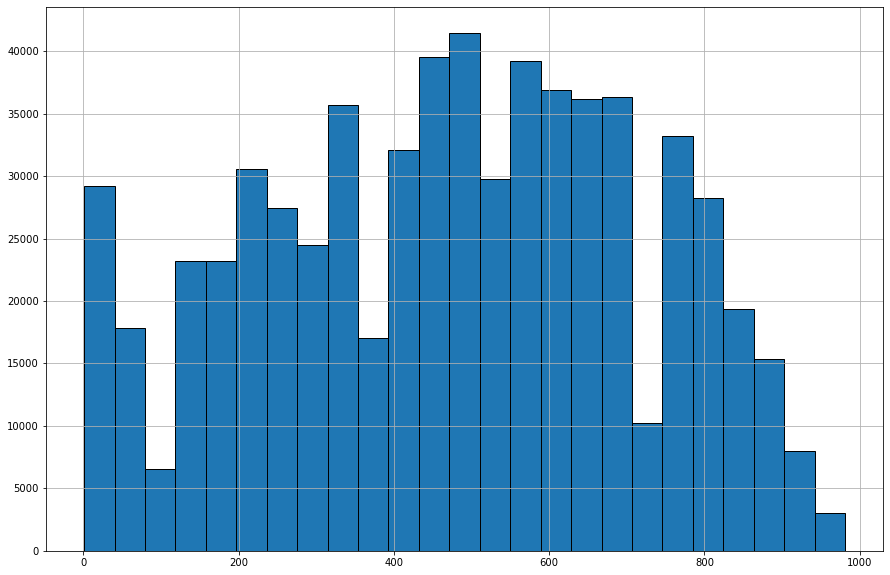

In [61]:
#histograph of user_id counts
df.user_id.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [62]:
#sns is having issues with index as it is showing duplicates:
df.index.is_unique

False

In [63]:
#dropping index duplicates
df=df.loc[~df.index.duplicated(), :]

In [64]:
#splitting webdev and datascience into two different df:
wd = df[df.program_id != 'Data Science']
ds = df[df.program_id == 'Data Science']

### Active Students with low curriculum access during each program:

In [65]:
#Ray's code to filter dataframe for time where students are active during their programs
active_wd = wd.loc[(wd.index >= wd.start_date) & (wd.index <= wd.end_date)]
active_ds = ds.loc[(ds.index >= ds.start_date) & (ds.index <= ds.end_date)]

#### WEB DEV:

In [66]:
#webdev students with lowest log access count:
hardly_access_wd = active_wd.groupby('user_id').size().sort_values().head(20)
hardly_access_wd

user_id
832     1
278     2
956     3
539     3
941     5
388     7
812     7
572    11
889    12
340    13
64     13
963    13
968    13
961    14
24     17
49     18
41     22
371    24
772    24
976    26
dtype: int64

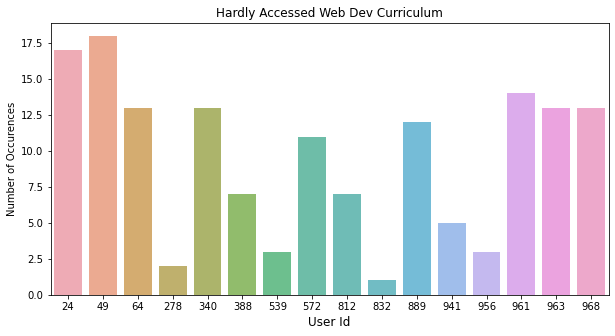

In [67]:
#histogram of these users under 20 logged access dates:
user_id_count = active_wd.groupby('user_id').size().sort_values()
user_id_count = user_id_count[:16]
plt.figure(figsize=(10,5))
sns.barplot(user_id_count.index, user_id_count.values, alpha=0.8)
plt.title ('Hardly Accessed Web Dev Curriculum')
plt.ylabel('Number of Occurences')
plt.xlabel('User Id', fontsize=12)
plt.show()


#### Data Science:

In [68]:
#looking at ds active students that had lowest curriculum log access counts
active_ds.groupby('user_id').size().sort_values().head()

user_id
679      4
697      7
839     43
902    114
780    132
dtype: int64

In [69]:
#ds students with lowest log access count:
hardly_access_ds = active_ds.groupby('user_id').size().sort_values().head(3)
hardly_access_ds

user_id
679     4
697     7
839    43
dtype: int64

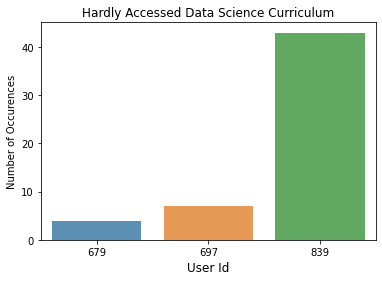

In [70]:
#histogram of these 3 users under 114 access logs on curriculum:
sns.barplot(hardly_access_ds.index, hardly_access_ds.values, alpha=0.8)
plt.title ('Hardly Accessed Data Science Curriculum')
plt.ylabel('Number of Occurences')
plt.xlabel('User Id', fontsize=12)
plt.show()


#### Can we look at users' access log times? (help determine any web scrapers)

In [71]:
#adding hour column to df for hours shown:
df['hour'] = pd.to_datetime(df.time).dt.hour
df.head(1)

,date,time,path,user_id,ip,name,start_date,end_date,program_id,hour
access_date,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,97.105.19.61,Hampton,2015-09-22,2016-02-06,Web Development,9


In [72]:
#showing hours these hardly accessed students logged in at:


<AxesSubplot:xlabel='user_id', ylabel='Count'>

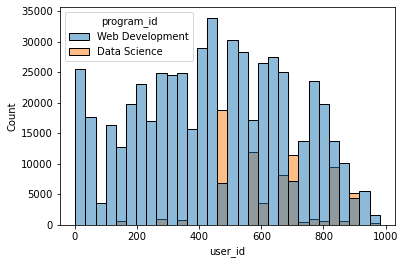

In [73]:
#user_id to cohort: are there student ranges here?
sns.histplot(data=df, x=df.user_id, hue=df.program_id, bins=30)

#### Question: Are there overlaps or recycling happening with user_id?

<AxesSubplot:xlabel='user_id', ylabel='Count'>

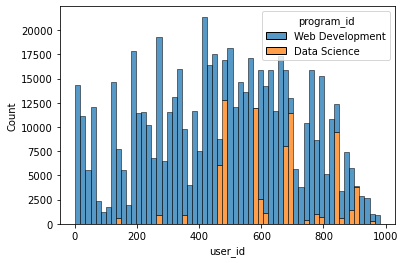

In [74]:
#user_id to cohort: are there student ranges here?
sns.histplot(data=df, x=df.user_id, hue=df.program_id, bins=60, multiple="stack")